In [ ]:
#Basic pre-reqs:

import torch

def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric

import numpy as np
from torch.autograd import Variable
from matplotlib import pyplot as plt
import torch
from torch import nn
import math
from torch.functional import F
from torch.optim import Adam
from torch_geometric.nn import MessagePassing, global_max_pool
from torchvision import datasets, transforms
from torch_geometric.data import Data, DataLoader
import torch.utils.data as data_utils
import torch_geometric
from torch_scatter import scatter_max
import dataclasses
import networkx as nx
from typing import *
from tqdm import tqdm
import os
import jax
from scipy.integrate import odeint
from torch_geometric.nn import GCNConv
import copy

from torch_geometric.utils import add_self_loops, degree, remove_self_loops

NUM_EPOCHS = 20
LR = 5e-4
device = torch.device("cuda")
%matplotlib inline

Looking in links: https://pytorch-geometric.com/whl/torch-2.0.1+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 50.4 MB/s eta 0:00:00
Looking in links: https://pytorch-geometric.com/whl/torch-2.0.1+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 39.6 MB/s eta 0:00:00
Looking in links: https://pytorch-geometric.com/whl/torch-2.0.1+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 31.4 MB/s eta 0:00:00
Looking in links: https://pytorch-geometric.com/whl/torch-2.0.1+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 886.6/886.6 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 10.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch-geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910454 sha256=4e2b0de88c08e3b2b2b80c7ad67b7b15079437b6ba6cca0e220b8305b576


## Training Utilities

In [ ]:

@dataclasses.dataclass
class TrainResult:
    r"""
    A collection containing everything we need to know about the training results
    """

    num_epochs: int
    lr: float

    # The trained model
    model: nn.Module

    # Training loss (saved at each iteration in `train_epoch`)
    train_losses: List[float]

    # Training accuracies, before training and after each epoch
    train_accs: List[float]

    # Validation accuracies, before training and after each epoch
    val_accs: List[float]

def learning_curve(result: TrainResult, *, title: str = 'Learning Curve'):
    r"""
    Plot the training loss, training accuracy, and validation accuracy versus
    epochs taken.
    """
    fig, ax_loss = plt.subplots(figsize=(8, 5))
    ax_loss.set_title(title, fontsize=16)
    ax_loss.set_xlabel('Epoch', fontsize=12)

    l_trloss = ax_loss.plot(
        torch.arange(len(result.train_losses)) / len(result.train_losses) * result.num_epochs,
        result.train_losses,
        label='Train loss',
        color='C0',
    )
    ax_loss.set_ylim(0, max(result.train_losses))
    ax_loss.set_ylabel('Train loss', color='C0', fontsize=12)
    ax_loss.tick_params(axis='y', labelcolor='C0')

    ax_acc = ax_loss.twinx()
    if len(result.val_accs):
        l_valacc = ax_acc.plot(result.val_accs, label='Val', color='C1')
    else:
        l_valacc = ()
    ax_acc.set_ylim(0, max(max(result.val_accs), 1))
    ax_acc.set_ylabel('Validation', color='C1', fontsize=12)
    ax_acc.tick_params(axis='y', labelcolor='C1')

    lines = l_trloss + l_valacc

    ax_loss.legend(lines, [l.get_label() for l in lines], loc='upper left', fontsize=13)

def train_nn(model, train_dataset, test_dataset, batch_size=32, num_epochs=NUM_EPOCHS, lr=LR, graph=True, criterion=nn.CrossEntropyLoss(), regression=True):

    train_result = TrainResult(num_epochs, lr, model, train_losses = [], train_accs=[], val_accs=[])

    if(graph):
        train_loader = torch_geometric.loader.DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
        test_loader = torch_geometric.loader.DataLoader(test_dataset, batch_size = batch_size, shuffle=False)
    else:
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
        test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle=False)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.train()
    total_train = 0
    for epoch in range(num_epochs):

        model.train()
        for datapoint in tqdm(train_loader):
            if(graph):
                datapoint = datapoint.to(device)
                X, y = datapoint, datapoint.y
            else:
                X, y = datapoint[0].to(device), datapoint[1].to(device)
            optimizer.zero_grad()
            output = model(X)

            loss = criterion(output, y)
            train_result.train_losses.append(loss.item())
            total_train += loss.item()
            loss.backward()
            optimizer.step()

        total_train = total_train/len(train_loader)

        model.eval()
        total_val = 0
        with torch.no_grad():
            for bidx, datapoint in enumerate(test_loader):
                if(graph):
                    datapoint = datapoint.to(device)
                    X, y = datapoint, datapoint.y
                else:
                    X, y = datapoint[0].to(device), datapoint[1].to(device)
                output = model(X)
                if(regression):
                    total_val += criterion(output, y).item()
                else:
                    total_val += torch.sum(torch.argmax(output, dim=-1)==y).item()/output.size(dim=0)
        train_result.val_accs.append(total_val/len(test_loader))

        if(regression):
            print("Epoch {}: Train Loss={} Validation Loss={}".format(epoch, total_train, train_result.val_accs[-1]))
        else:
            print("Epoch {}: Train Loss={} Validation Accuracy={}%".format(epoch, total_train, train_result.val_accs[-1]*100))

    return train_result

## GNN Architecture

Graph neural networks subscribe to a slightly different API from [pytorch geometric](https://pytorch-geometric.readthedocs.io/en/latest/). In addition to the input features of shape [N, in_channels] for N nodes and `in_channels` node features per node, they also expect an edge_index tensor of shape [2, E] for E edges that specifies the *structure* of the graph.

Instead of sliding window convolutions used in the CNN, Graph neural networks use graph convolutions implemented via message passing. There are many ways to aggregate and normalize messages during graph convolutions. Here we will be using [Graph Convolutional Networks](https://arxiv.org/abs/1609.02907) (GCN).

GCNs normalize the messages by *both* the degrees from the source node and target node. More specifically, GCN message passing has the following form.

$$x_i^{(k)} = \sum_{j\in{\mathcal{N}(i)\cup{\{i\}}}}C\Big(W\cdot{x_j^{(k-1)}}\Big)+b$$


$$C=\frac{1}{\sqrt{\text{deg}(i)}\cdot\sqrt{\text{deg}(j)}}$$

Read the following code to see how a graph convolutional layer can be implemented. These layers are then interleaved with ReLU nonlinearities and then passed through `scatter_max` ([docs](https://pytorch-scatter.readthedocs.io/en/1.3.0/functions/max.html)). Think about:
  - Why is `scatter_max` needed (Hint: try not including it and see what happens)?
  - How does `scatter_max` alter the shape of the activations

In [ ]:

class GCNConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super().__init__(aggr='add')
        self.lin = nn.Linear(in_channels, out_channels, bias=False)
        self.bias = nn.Parameter(torch.Tensor(out_channels))

        self.reset_parameters()

    def reset_parameters(self):
        self.lin.reset_parameters()
        self.bias.data.zero_()

    def forward(self, x, edge_index):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))
        x = self.lin(x)

        row, col = edge_index
        deg = degree(col, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)

        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]


        out = self.propagate(edge_index, x=x, norm=norm)
        out += self.bias

        return out

    def message(self, x_j, norm):
        return norm.view(-1, 1) * x_j

class GNN(torch.nn.Module):
    def __init__(self, in_channels=3, out_channels = 10):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(in_channels, 16)
        self.conv2 = GCNConv(16, 32)
        self.conv3 = GCNConv(32, 48)
        self.conv4 = GCNConv(48, 64)
        self.linear1 = torch.nn.Linear(64,64)
        self.linear2 = torch.nn.Linear(64,out_channels)

    def forward(self, data):
        # Graph convolutional layers
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = self.conv4(x, edge_index)
        x = F.relu(x)

        # scatter_max
        # x, _ = scatter_max(x, data.batch, dim=0)

        # linear
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        return  x

# Molecules

In this problem we will be trying to predict water solubility of a molecule from its chemical structure. The water solubility of a molecule is a measure of the amount of chemical substance that can dissolve in water at a specific temperature. The unit of  solubility is in mg/L.

Molecules can be represented in a graph structure in which the nodes are atoms and the edges are bonds between atoms or as an image in the form of a SMILES line notation. Both representations have the same information.

Fill in the rest of the code.

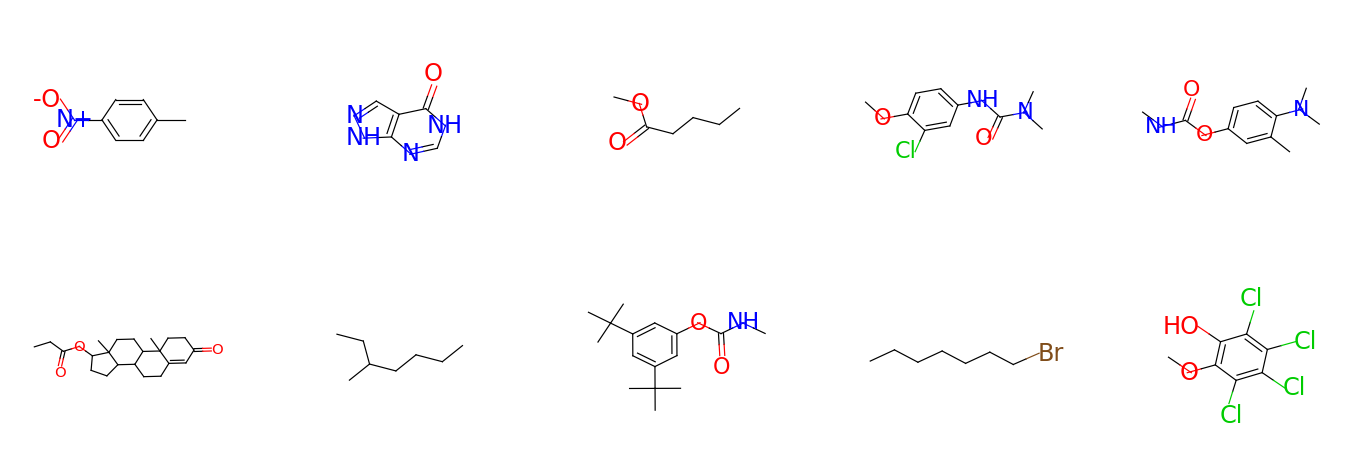

In [ ]:

!pip install torchdrug

from torch_geometric.datasets import MoleculeNet
from torchdrug import data as tddata
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
from IPython.display import clear_output

dataset = MoleculeNet(root='/tmp/ESOL', name='ESOL')
dataset = dataset.shuffle()

graph_dataset = []
image_dataset = []
data_els = []
for data_el in tqdm(dataset):
    try:
        mol = tddata.Molecule.from_smiles(data_el.smiles)
    except:
        continue

    fig = Figure(figsize=(2, 2))
    canvas = FigureCanvas(fig)
    ax = fig.gca()

    ax.axis('off')
    p = mol.visualize(ax=ax)
    canvas.draw()       # draw the canvas, cache the renderer

    image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    image_from_plot = image_from_plot.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    plt.close(fig)
    plt.cla()
    plt.close("all")
    if(data_el.x.shape[0]>0):
        image_dataset.append((torch.tensor(image_from_plot).type(torch.FloatTensor).permute(2, 0, 1), torch.squeeze(data_el.y)))
        graph_dataset.append(Data(x=data_el.x.type(torch.FloatTensor), edge_index=data_el.edge_index, edge_attr=data_el.edge_attr, smiles=data_el.smiles, y=data_el.y))
        data_els.append(data_el)

num_train = 2*len(graph_dataset)//3



100%|██████████| 1128/1128 [02:31<00:00,  7.44it/s]


In [ ]:
from rdkit.Chem import inchi
num_train = 2*len(graph_dataset)//3

train_dataset_tox = graph_dataset[:num_train]
test_dataset_tox = graph_dataset[num_train:]

# FIX ME: Instantiate the GNN model implemented above with 9 input channels, 1 output channel
model = GNN(in_channels = 9, out_channels = 1)
model.to(device)

# FIX ME: Train using train_nn method implemented above with the molecules dataset, learning rate 5e-4, MSE loss and for 100 epochs
gnn_molecule_results = train_nn(model, train_dataset_tox, test_dataset_tox, num_epochs=100, lr=5e-4, criterion=nn.MSELoss())

%matplotlib inline
learning_curve(gnn_molecule_results)

  0%|          | 0/24 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([326, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/24 [00:00<?, ?it/s]


RuntimeError: ignored